### Develop a predictive model using SAS, R, Python or SPSS Modeller to automatically notify AHG leaders 90 days before a customer is due to churn, i.e. when a customer’s churn propensity exceeds a specific threshold, say 0.7
#### Solution Approach 
#### Define churn – Churn is defined as any customer who didn’t make any purchase within the last 8 months of Business transaction i.e. any customer whose maximum/last transaction date is less than 31/10/2007. This might vary based on the version of AdventureworksDW that you are using. 
#### Carry exploratory analysis to understand the profile of churners using their demographic, transactional and attitudinal data. You can employ a decision tree to generate a rule set that can help you describe these customers or plot a distribution of the demographic variables vs the Churn variable (target)
#### As part of your feature engineering, use RFM analysis to create recency, frequency and monetary(lifetime value) attributes for each customer. Using the derived RFM variables or RFM Scores, create a clustering model (unsupervised technique) using K means or other clustering algorithms to generate customer segments (clusters – use elbow method to select the best number of clusters). The cluster variable should be used as part of your modelling and scoring variables.
#### Churn variable is your target variable for your modelling exercise
#### You must have a single customer view i.e the final dataset must have a single customer data per row no duplicates 
#### Follow the modelling phases including, statistical testing(Chi-square tests, correlations etc) to test for multi collinearity and over fitting, investigate the distributions, Identify outliers, extreme values or spurious values, impute missing values where applicable, Carry out feature selection, partition the data into training, testing or validation or use cross validation technique, develop various models and select champion model
#### Deploy or score model on an unseen dataset/hold out sample, this dataset must not be included in the model development phase.
#### Re validate your model before rolling out the main marketing campaign (A/B testing is applicable for a response model)


In [306]:
%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# data colelctFion and preprocessing
#from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [307]:
# connecting to SQL server

pyodbc.connect

cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=DESKTOP-TI5OC9C;"
            "Database=AdventureWorksDW2017;"
            "Trusted_Connection=yes;")


cnxn = pyodbc.connect(cnxn_str)


### Import Fact Internet Sales

In [308]:
fis = pd.read_sql("""SELECT 
[CustomerKey],
[SalesTerritoryKey],
[OrderQuantity],
[SalesOrderNumber],
[SalesAmount],
[OrderDate]
FROM [dbo].[FactInternetSales] 
""", cnxn)

In [309]:
fis.head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
0,21768,6,1,SO43697,3578.27,2010-12-29
1,28389,7,1,SO43698,3399.99,2010-12-29
2,25863,1,1,SO43699,3399.99,2010-12-29
3,14501,4,1,SO43700,699.10,2010-12-29
4,11003,9,1,SO43701,3399.99,2010-12-29


In [310]:
fis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerKey        60398 non-null  int64         
 1   SalesTerritoryKey  60398 non-null  int64         
 2   OrderQuantity      60398 non-null  int64         
 3   SalesOrderNumber   60398 non-null  object        
 4   SalesAmount        60398 non-null  float64       
 5   OrderDate          60398 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.8+ MB


In [311]:
max(fis.OrderDate) # For our Churn, we will subtract 8 months from this date to create cutoff period

Timestamp('2014-01-28 00:00:00')

In [312]:
fis.count().head()

CustomerKey          60398
SalesTerritoryKey    60398
OrderQuantity        60398
SalesOrderNumber     60398
SalesAmount          60398
dtype: int64

In [313]:
fis.sort_values(['CustomerKey', 'SalesOrderNumber']).head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
96,11000,9,1,SO43793,3399.99,2011-01-19
6396,11000,9,1,SO51522,2319.99,2013-01-18
6397,11000,9,1,SO51522,21.98,2013-01-18
19223,11000,9,1,SO57418,2384.07,2013-05-03
19224,11000,9,1,SO57418,28.99,2013-05-03


In [314]:
# checking for duplicates
print(any(fis.duplicated()))

True


In [315]:
fis.isnull().sum()

CustomerKey          0
SalesTerritoryKey    0
OrderQuantity        0
SalesOrderNumber     0
SalesAmount          0
OrderDate            0
dtype: int64

### Summarize & aggregate the facts internet sales data

In [316]:
new_fis = fis.groupby(['CustomerKey','SalesOrderNumber','OrderDate','SalesTerritoryKey']).agg({'SalesAmount':'sum','OrderQuantity':'sum'})

new_fis.head()

SalesAmount  \
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                
11000       SO43793          2011-01-19 9                      3399.99   
            SO51522          2013-01-18 9                      2341.97   
            SO57418          2013-05-03 9                      2507.03   
11001       SO43767          2011-01-15 9                      3374.99   
            SO51493          2013-01-16 9                      2419.93   

                                                           OrderQuantity  
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                 
11000       SO43793          2011-01-19 9                              1  
            SO51522          2013-01-18 9                              2  
            SO57418          2013-05-03 9                              5  
11001       SO43767          2011-01-15 9                              1  
            SO51493          2013-01-16 9                              6

In [317]:
new_fis = new_fis.reset_index()

In [318]:
# Creating new ffeature for data-timeBWtrans

new_fis['timeBWtrans'] = new_fis.sort_values(['CustomerKey','OrderDate']).groupby(['CustomerKey'])['OrderDate'].diff()

In [319]:
new_fis['timeBWtrans'].dtype

dtype('<m8[ns]')

In [320]:
#convert the new feature to days
new_fis['timeBWtrans'] = new_fis['timeBWtrans'].astype('timedelta64[D]')


In [321]:
new_fis.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,NaN
1,11000,SO51522,2013-01-18,9,2341.97,2,730.00
2,11000,SO57418,2013-05-03,9,2507.03,5,105.00
3,11001,SO43767,2011-01-15,9,3374.99,1,NaN
4,11001,SO51493,2013-01-16,9,2419.93,6,732.00


In [322]:
#Replace the NaN with 0
new_fis['timeBWtrans'] = new_fis['timeBWtrans'].fillna(0).astype(int) 

new_fis.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,0
1,11000,SO51522,2013-01-18,9,2341.97,2,730
2,11000,SO57418,2013-05-03,9,2507.03,5,105
3,11001,SO43767,2011-01-15,9,3374.99,1,0
4,11001,SO51493,2013-01-16,9,2419.93,6,732


In [323]:
#summarise the fact internet sales -  fis data
new_fis = new_fis.groupby(['CustomerKey','SalesTerritoryKey']).agg({'SalesAmount':['sum','mean','min','max'],'SalesOrderNumber':'count','OrderDate':['min','max'],'timeBWtrans':['mean'],'OrderQuantity':['sum','mean','min','max']}).reset_index()

In [324]:
new_fis.head()

CustomerKey SalesTerritoryKey SalesAmount                          \
                                        sum    mean     min     max   
0       11000                 9     8248.99 2749.66 2341.97 3399.99   
1       11001                 9     6383.88 2127.96  588.96 3374.99   
2       11002                 9     8114.04 2704.68 2294.99 3399.99   
3       11003                 9     8139.29 2713.10 2318.96 3399.99   
4       11004                 9     8196.01 2732.00 2376.96 3399.99   

  SalesOrderNumber  OrderDate            timeBWtrans OrderQuantity           \
             count        min        max        mean           sum mean min   
0                3 2011-01-19 2013-05-03      278.33             8 2.67   1   
1                3 2011-01-15 2013-12-10      353.33            11 3.67   1   
2                3 2011-01-07 2013-02-23      259.33             4 1.33   1   
3                3 2010-12-29 2013-05-10      287.67             9 3.00   1   
4                3 2011-01-23 2013-05-01      276.33             6 2.00   1   

       
  max  
0   5  
1   6  
2   2  
3   4  
4   3

In [325]:
#Join the field names to the newly aggregate fields names
new_fis.columns = ["_".join(x) for x in new_fis.columns.ravel()]


C:\Users\henna\AppData\Local\Temp/ipykernel_24976/1493834360.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  new_fis.columns = ["_".join(x) for x in new_fis.columns.ravel()]


In [326]:
new_fis.count().head()

CustomerKey_          18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [327]:
#Rename CustomerKey_ to CustomerKey
new_fis = new_fis.rename(columns={'CustomerKey_': 'CustomerKey'})

In [328]:
print(any(new_fis['CustomerKey'].duplicated()))

False


### Import DIMCUSTOMER table from SQL


In [329]:
custmrtble = pd.read_sql_query("""
SELECT 
[CustomerKey],
[BirthDate],
[MaritalStatus],
[Gender],
[YearlyIncome],
[TotalChildren],
[NumberChildrenAtHome],
[EnglishEducation],
[EnglishOccupation],
[HouseOwnerFlag],
[NumberCarsOwned],
[DateFirstPurchase],
[CommuteDistance]
FROM [dbo].[DimCustomer]
""",cnxn)

In [330]:
custmrtble.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1971-10-06,M,M,90000.00,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,1976-05-10,S,M,60000.00,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,1971-02-09,M,M,60000.00,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,1973-08-14,S,F,70000.00,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,1979-08-05,S,F,80000.00,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [331]:
print(any(custmrtble['CustomerKey'].duplicated()))

False


### Import factsinternetsales reason

In [332]:
fisreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]
""""",cnxn)

In [333]:
fisreason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey
0,SO43697,1,5
1,SO43697,1,9
2,SO43702,1,5
3,SO43702,1,9
4,SO43703,1,5


### Import the DimSalesReason

In [334]:
# Import the DimSalesReason
SalesReason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]
""",cnxn)

In [335]:
SalesReason.head(10)

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other
5,6,6,Review,Other
6,7,7,Demo Event,Marketing
7,8,8,Sponsorship,Marketing
8,9,9,Quality,Other
9,10,10,Other,Other


In [336]:
SalesReason.count().head()

SalesReasonKey             10
SalesReasonAlternateKey    10
SalesReasonName            10
SalesReasonReasonType      10
dtype: int64

In [337]:
# join both the new_fis table with the custmrtble
result = pd.merge(new_fis,
                 custmrtble,
                 on = 'CustomerKey')

In [338]:
result.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,9,8248.99,2749.66,2341.97,3399.99,3,2011-01-19,2013-05-03,278.33,...,M,90000.00,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,9,6383.88,2127.96,588.96,3374.99,3,2011-01-15,2013-12-10,353.33,...,M,60000.00,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,9,8114.04,2704.68,2294.99,3399.99,3,2011-01-07,2013-02-23,259.33,...,M,60000.00,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,9,8139.29,2713.10,2318.96,3399.99,3,2010-12-29,2013-05-10,287.67,...,F,70000.00,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,9,8196.01,2732.00,2376.96,3399.99,3,2011-01-23,2013-05-01,276.33,...,F,80000.00,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [339]:
# join sales reason with fisreason to create one clear, concise table

reason = pd.merge(fisreason,
                 SalesReason,
                 on = 'SalesReasonKey')

In [340]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


In [341]:
# Since I have joined two tables I am checking both tables for duplicates in the data

print(any(reason['SalesOrderNumber'].duplicated()))

True


In [342]:
reason.head(10) # checking for duplicates

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other
5,SO43709,1,5,5,Manufacturer,Other
6,SO43710,1,5,5,Manufacturer,Other
7,SO43711,1,5,5,Manufacturer,Other
8,SO43712,1,5,5,Manufacturer,Other
9,SO43713,1,5,5,Manufacturer,Other


In [343]:
reason[reason['SalesOrderNumber'] == 'SO43702']
#Under the salesreasonname there seems to be two reasons why the customer bought that product

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
1,SO43702,1,5,5,Manufacturer,Other
1819,SO43702,1,9,9,Quality,Other


In [344]:
list(reason.SalesReasonName.unique())

['Manufacturer',
 'Quality',
 'On Promotion',
 'Review',
 'Price',
 'Other',
 'Television  Advertisement']

In [345]:
# dummify the sales reason name column to make its cntents variables
reasonn = pd.get_dummies(reason.SalesReasonName,columns = ['Price','On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event''Sponsorship', 'Quality', 'Other'])

In [346]:
reasonn.head()

,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [347]:
reason = pd.concat([reason, reasonn], axis=1)

In [348]:
print(any(reason['SalesOrderNumber'].duplicated()))

True


In [349]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [350]:
#Re Import Factinternetsales from SQL Datawarehouse
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", cnxn)

In [351]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fctintsales,
                 reason,
                 on='SalesOrderNumber')

In [352]:
reason.count().head()

CustomerKey                188157
SalesOrderNumber           188157
SalesOrderLineNumber       188157
SalesReasonKey             188157
SalesReasonAlternateKey    188157
dtype: int64

In [353]:
#Aggregate Sales Reason to prevent duplication of customer information
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'})

reason.head()

,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
CustomerKey,,,,,,,
11000,0,1,0,1,0,0,0
11001,0,0,0,1,0,0,0
11002,0,1,0,0,0,0,0
11003,0,0,0,1,0,0,0
11004,0,0,0,1,0,0,0


In [354]:
#Reset the index to create a proper structure for the dataframe
reason = reason.reset_index()

In [355]:
reason.head()

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [356]:
#checking for duplicates
print(any(reason['CustomerKey'].duplicated()))

False


In [357]:
reason.count().head()

CustomerKey     17022
Manufacturer    17022
On Promotion    17022
Other           17022
Price           17022
dtype: int64

In [358]:
# MERGE ALL THE DIFFERENT DATASETS INTO ONE 
final_data = pd.merge(result,
                     reason,
                     on = 'CustomerKey', how = 'left')

In [359]:
final_data.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,9,8248.99,2749.66,2341.97,3399.99,3,2011-01-19,2013-05-03,278.33,...,0,2011-01-19,1-2 Miles,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,11001,9,6383.88,2127.96,588.96,3374.99,3,2011-01-15,2013-12-10,353.33,...,1,2011-01-15,0-1 Miles,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,11002,9,8114.04,2704.68,2294.99,3399.99,3,2011-01-07,2013-02-23,259.33,...,1,2011-01-07,2-5 Miles,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,11003,9,8139.29,2713.10,2318.96,3399.99,3,2010-12-29,2013-05-10,287.67,...,1,2010-12-29,5-10 Miles,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,11004,9,8196.01,2732.00,2376.96,3399.99,3,2011-01-23,2013-05-01,276.33,...,4,2011-01-23,1-2 Miles,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [360]:
# deriving extra fields 
final_data['CustomerTenure'] = ((final_data['OrderDate_max'].dt.date - final_data['DateFirstPurchase'])/np.timedelta64(1, 'M')).astype(int)
final_data['Customer_Age'] = ((final_data['OrderDate_max'].dt.date -  final_data['BirthDate'])/np.timedelta64(1, 'Y')).astype(int)
final_data['Last_purchase_date'] = final_data['OrderDate_max'].dt.date
final_data['Cuttoff_date'] = '2013-05-31'

In [361]:
#Convert dates from objects to date formats

final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")



In [362]:
#Create the Target variable where 1 = Churn and 0 = non churn
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'] , 1, 0)

In [363]:
final_data.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Last_purchase_date,Cuttoff_date,Churn
0,11000,9,8248.99,2749.66,2341.97,3399.99,3,2011-01-19,2013-05-03,278.33,...,0.00,1.00,0.00,0.00,0.00,27,41,2013-05-03,2013-05-31,1
1,11001,9,6383.88,2127.96,588.96,3374.99,3,2011-01-15,2013-12-10,353.33,...,0.00,1.00,0.00,0.00,0.00,34,37,2013-12-10,2013-05-31,0
2,11002,9,8114.04,2704.68,2294.99,3399.99,3,2011-01-07,2013-02-23,259.33,...,0.00,0.00,0.00,0.00,0.00,25,42,2013-02-23,2013-05-31,1
3,11003,9,8139.29,2713.10,2318.96,3399.99,3,2010-12-29,2013-05-10,287.67,...,0.00,1.00,0.00,0.00,0.00,28,39,2013-05-10,2013-05-31,1
4,11004,9,8196.01,2732.00,2376.96,3399.99,3,2011-01-23,2013-05-01,276.33,...,0.00,1.00,0.00,0.00,0.00,27,33,2013-05-01,2013-05-31,1


In [364]:
#Rename SalesTerritoryKey_ to SalesTerritoryKey
final_data = final_data.rename(columns={'SalesTerritoryKey_': 'SalesTerritoryKey'})

### Import sales region table from SQL

In [365]:
salesregion = pd.read_sql_query(""" 
SELECT 
[SalesTerritoryKey], 
[SalesTerritoryCountry] AS 'SalesCountry', 
[SalesTerritoryGroup] AS 'SalesRegion'
FROM [dbo].[DimSalesTerritory] """,cnxn)

salesregion.head()



,SalesTerritoryKey,SalesCountry,SalesRegion
0,1,United States,North America
1,2,United States,North America
2,3,United States,North America
3,4,United States,North America
4,5,United States,North America


In [366]:
print(any(salesregion['SalesTerritoryKey'].duplicated()))

False


### MERGE ALL THE DIFFERENT DATASETS INTO ONE

In [367]:
final_data = pd.merge(final_data, salesregion, on = 'SalesTerritoryKey', how = 'left')

final_data.head()

,CustomerKey,SalesTerritoryKey,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Last_purchase_date,Cuttoff_date,Churn,SalesCountry,SalesRegion
0,11000,9,8248.99,2749.66,2341.97,3399.99,3,2011-01-19,2013-05-03,278.33,...,0.00,0.00,0.00,27,41,2013-05-03,2013-05-31,1,Australia,Pacific
1,11001,9,6383.88,2127.96,588.96,3374.99,3,2011-01-15,2013-12-10,353.33,...,0.00,0.00,0.00,34,37,2013-12-10,2013-05-31,0,Australia,Pacific
2,11002,9,8114.04,2704.68,2294.99,3399.99,3,2011-01-07,2013-02-23,259.33,...,0.00,0.00,0.00,25,42,2013-02-23,2013-05-31,1,Australia,Pacific
3,11003,9,8139.29,2713.10,2318.96,3399.99,3,2010-12-29,2013-05-10,287.67,...,0.00,0.00,0.00,28,39,2013-05-10,2013-05-31,1,Australia,Pacific
4,11004,9,8196.01,2732.00,2376.96,3399.99,3,2011-01-23,2013-05-01,276.33,...,0.00,0.00,0.00,27,33,2013-05-01,2013-05-31,1,Australia,Pacific


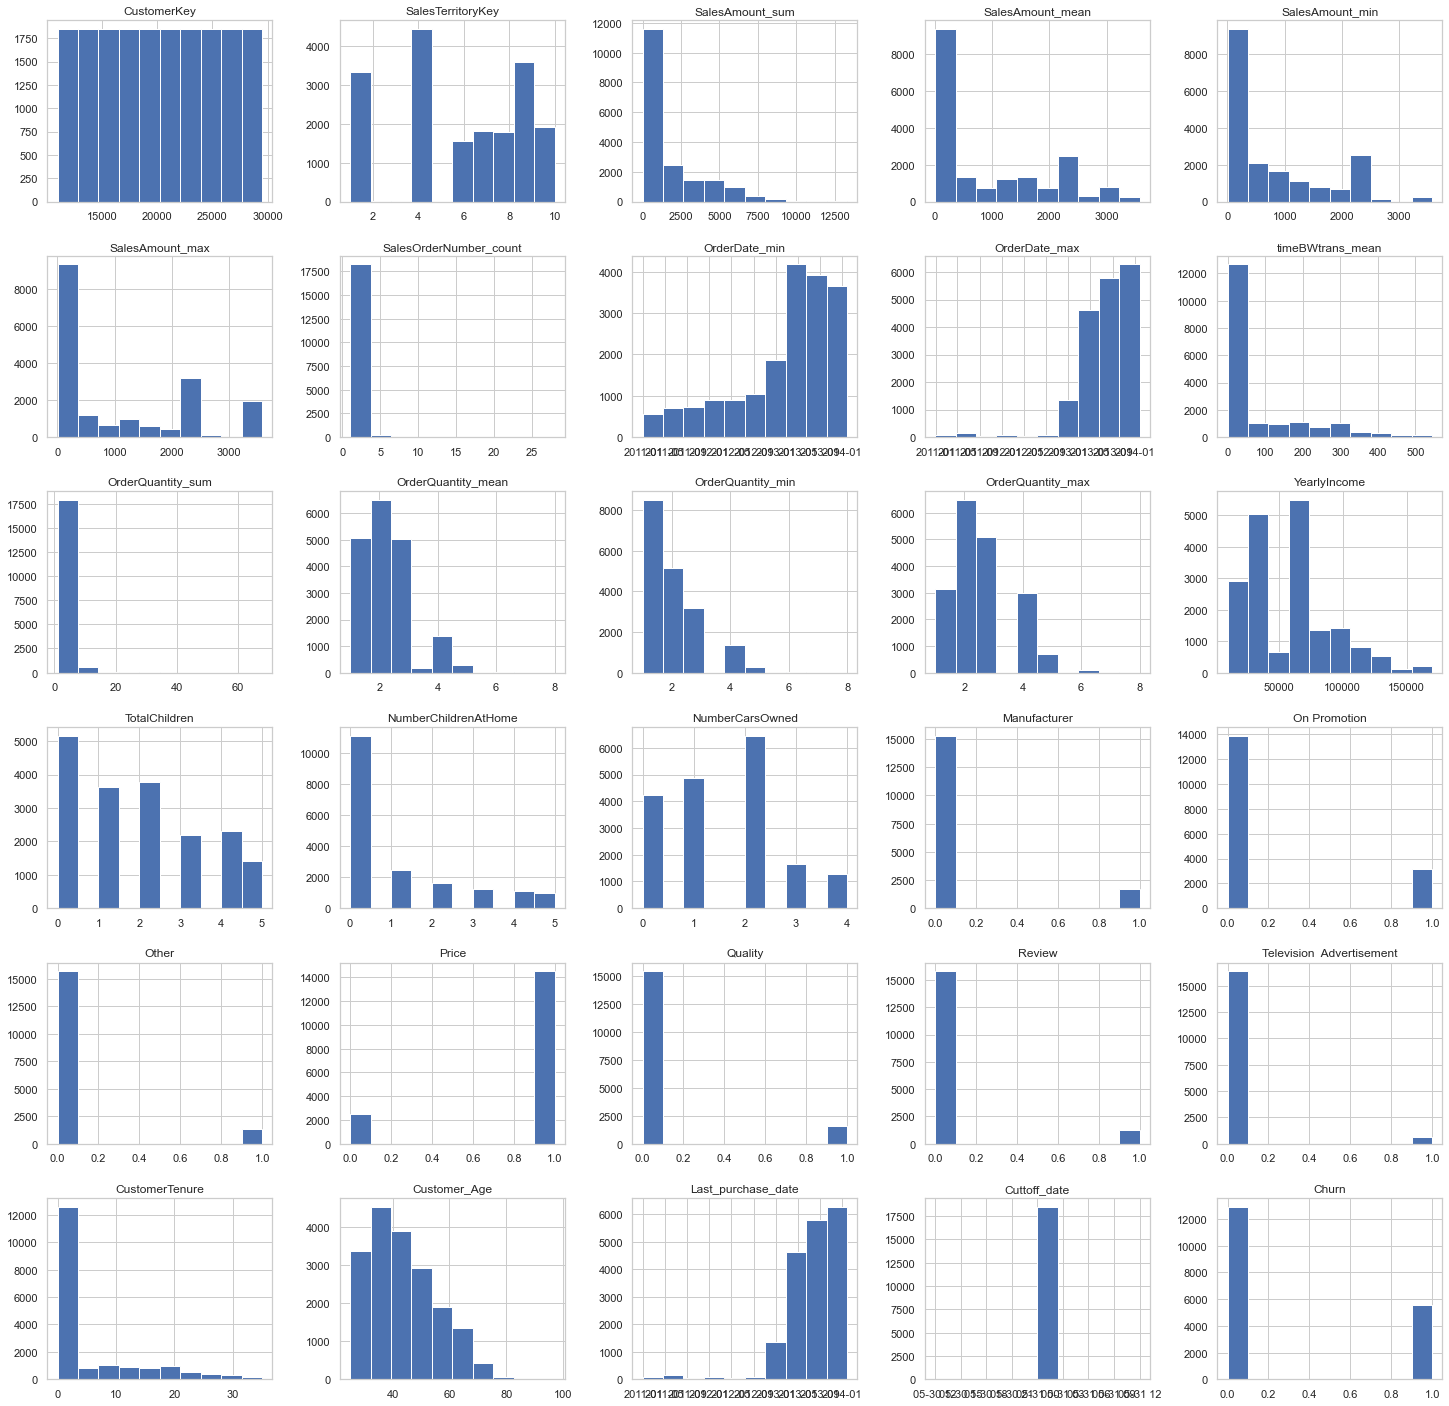

In [368]:
final_data.hist(figsize=(25,25))
plt.show()

In [369]:
final_data.dtypes

CustomerKey                           int64
SalesTerritoryKey                     int64
SalesAmount_sum                     float64
SalesAmount_mean                    float64
SalesAmount_min                     float64
SalesAmount_max                     float64
SalesOrderNumber_count                int64
OrderDate_min                datetime64[ns]
OrderDate_max                datetime64[ns]
timeBWtrans_mean                    float64
OrderQuantity_sum                     int64
OrderQuantity_mean                  float64
OrderQuantity_min                     int64
OrderQuantity_max                     int64
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
EnglishEducation                     object
EnglishOccupation                    object
HouseOwnerFlag                  

In [370]:
# Exclude features that have to do with time or dates
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64','object']
final_data = final_data.select_dtypes(include=numerics)

In [371]:
final_data.dtypes

CustomerKey                    int64
SalesTerritoryKey              int64
SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
timeBWtrans_mean             float64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
BirthDate                     object
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
DateFirstPurchase             object
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
P

In [372]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerKey                18484 non-null  int64  
 1   SalesTerritoryKey          18484 non-null  int64  
 2   SalesAmount_sum            18484 non-null  float64
 3   SalesAmount_mean           18484 non-null  float64
 4   SalesAmount_min            18484 non-null  float64
 5   SalesAmount_max            18484 non-null  float64
 6   SalesOrderNumber_count     18484 non-null  int64  
 7   timeBWtrans_mean           18484 non-null  float64
 8   OrderQuantity_sum          18484 non-null  int64  
 9   OrderQuantity_mean         18484 non-null  float64
 10  OrderQuantity_min          18484 non-null  int64  
 11  OrderQuantity_max          18484 non-null  int64  
 12  BirthDate                  18484 non-null  object 
 13  MaritalStatus              18484 non-null  obj

In [373]:
# Exclude features that are keys
final_data.drop(['CustomerKey','SalesTerritoryKey', 'timeBWtrans_mean', 'BirthDate','DateFirstPurchase' ], axis=1,inplace=True)

#### Excuding these sets of features is needed so that scoring data and your new dataste will have the same datatypes per feature

In [374]:
final_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [375]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalesAmount_sum            18484 non-null  float64
 1   SalesAmount_mean           18484 non-null  float64
 2   SalesAmount_min            18484 non-null  float64
 3   SalesAmount_max            18484 non-null  float64
 4   SalesOrderNumber_count     18484 non-null  int64  
 5   OrderQuantity_sum          18484 non-null  int64  
 6   OrderQuantity_mean         18484 non-null  float64
 7   OrderQuantity_min          18484 non-null  int64  
 8   OrderQuantity_max          18484 non-null  int64  
 9   MaritalStatus              18484 non-null  object 
 10  Gender                     18484 non-null  object 
 11  YearlyIncome               18484 non-null  float64
 12  TotalChildren              18484 non-null  int64  
 13  NumberChildrenAtHome       18484 non-null  int

In [376]:
final_data['Churn'].value_counts() # churners are 5559, non-churners are 12925

0    12925
1     5559
Name: Churn, dtype: int64

In [377]:
# divivding churner and non churners

churners = final_data.loc[final_data['Churn'] == 1]
churners['Churn'].value_counts()

1    5559
Name: Churn, dtype: int64

In [378]:
non_churners = final_data.loc[final_data['Churn'] == 0]
non_churners['Churn'].value_counts()

0    12925
Name: Churn, dtype: int64

### the next step is to divide the non_churners into 2 groups:
### 1.one group for trainning and testing
### 2.the other group for scoring the model
### 3.I will employ the train_test_split method for this

In [379]:
scoring_data,non_churners = train_test_split(non_churners,test_size=0.5,random_state=30)

In [380]:
# now I check the number of non_churners again

non_churners['Churn'].value_counts()

0    6463
Name: Churn, dtype: int64

### I am bringing together the non-CHURNERS & CHURNERS DATASTETS TO FORM ONE BIG ONE

In [381]:
modeling_data = pd.concat([churners,non_churners],ignore_index=True)

## Exploratory Data Analysis

<AxesSubplot:xlabel='Churn', ylabel='count'>

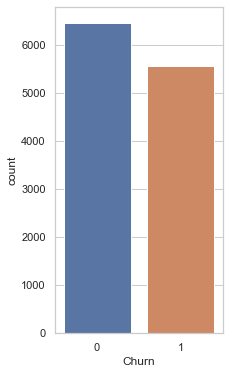

In [382]:
plt.figure(figsize=(3,6))
sns.countplot(x='Churn', data=modeling_data)

## Churn & Children

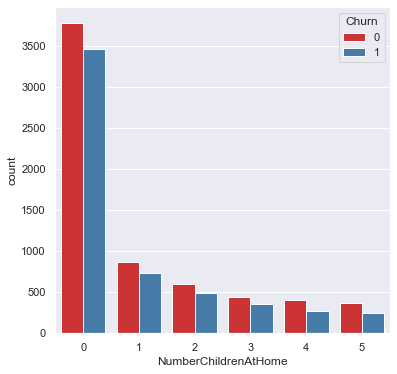

In [383]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='NumberChildrenAtHome',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers who are more likely to churn have fewer children than those who won't churn

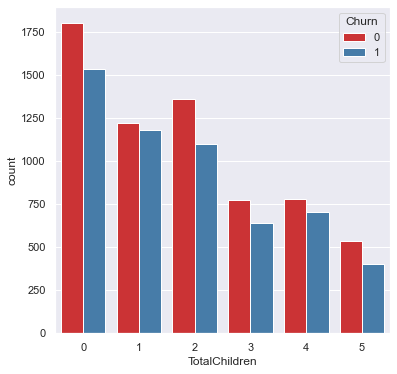

In [384]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='TotalChildren',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers with fewer total number of children in general are more likely to churn

## Churn & Customer Educational Background

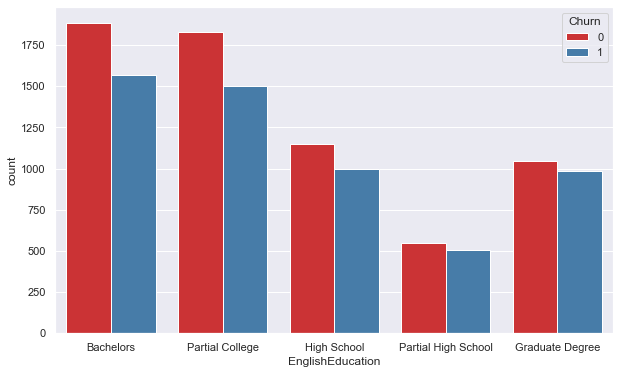

In [385]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='EnglishEducation',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# the data shows non-churners are more likely to have adegree of some kind than churners

## Churn & Customer Age

<AxesSubplot:ylabel='Frequency'>

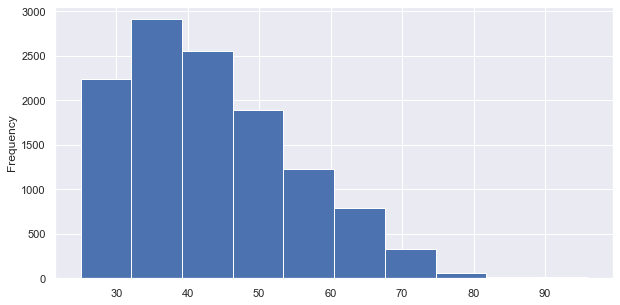

In [386]:
modeling_data['Customer_Age'].plot.hist(bins=10, figsize=(10,5))
# from the vizualisation we can tell that majority of the customers are between the ages of 30 and 50

Text(0.5, 0, 'Customer_Age')

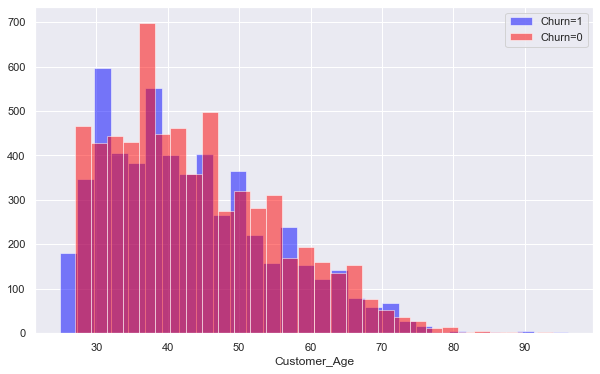

In [387]:
plt.figure(figsize=(10,6))
modeling_data[modeling_data['Churn']==1]['Customer_Age'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
modeling_data[modeling_data['Churn']==0]['Customer_Age'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Customer_Age')

## Churn & Customer Occupation

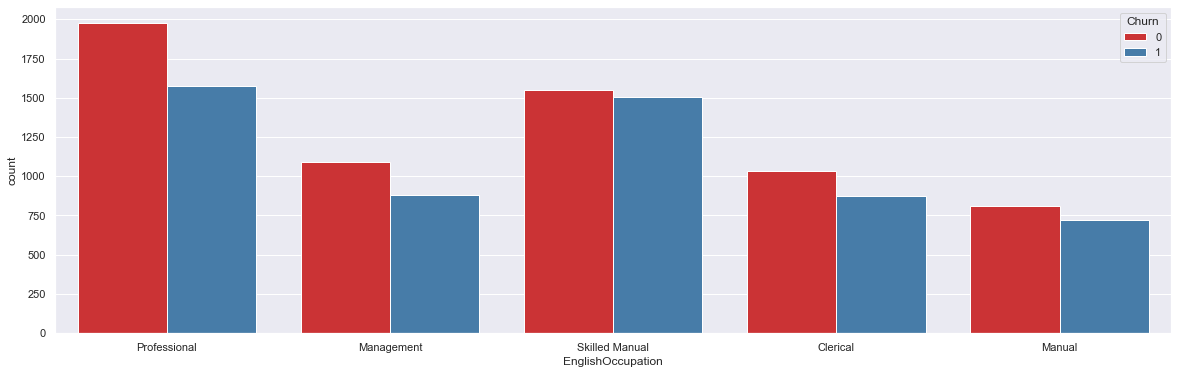

In [388]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,6))
sns.countplot(x='EnglishOccupation',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
 # From the visualization, we can tell that a bulk of potential churners happen to have professional 
# and skilled manual occupations

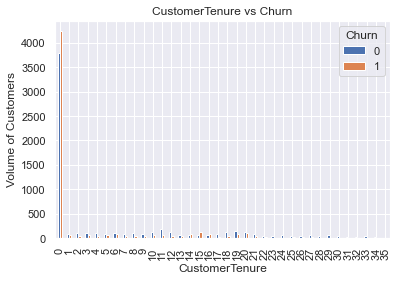

<Figure size 1440x432 with 0 Axes>

In [389]:
pd.crosstab(modeling_data.CustomerTenure,modeling_data.Churn).plot(kind='bar')
plt.title('CustomerTenure vs Churn')
plt.xlabel('CustomerTenure')
plt.ylabel('Volume of Customers')

plt.figure(figsize = (20,6))

plt.savefig('pur_fre_pout_bar')
# Customers are most likley to churn if they have been customers for less than 12 months.

Text(0.5, 0, 'CustomerTenure')

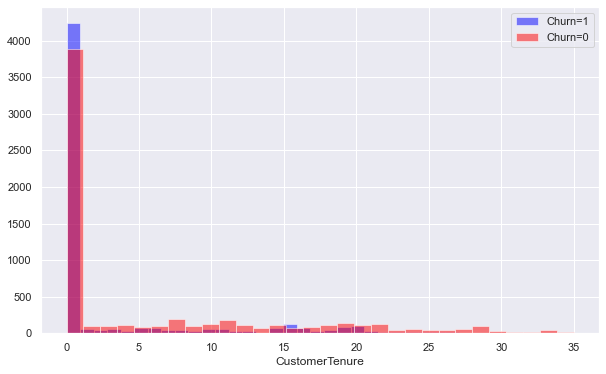

In [390]:
plt.figure(figsize=(10,6))
modeling_data[modeling_data['Churn']==1]['CustomerTenure'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
modeling_data[modeling_data['Churn']==0]['CustomerTenure'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('CustomerTenure')

## Churn & Customer Gender

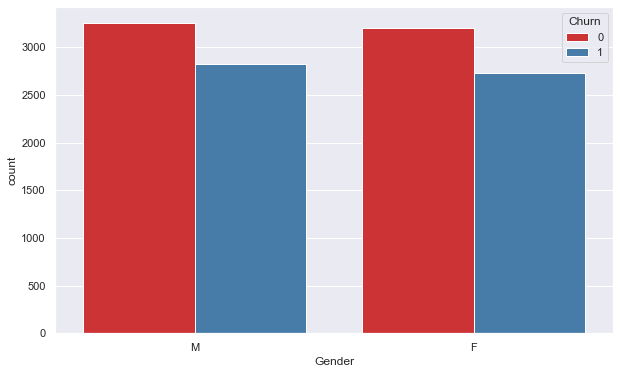

In [391]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='Gender',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()

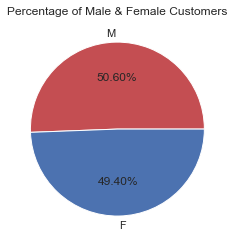

In [392]:
M = modeling_data.loc[modeling_data['Gender'] == 'M'].count()[0]
F = modeling_data.loc[modeling_data['Gender'] == 'F'].count()[0]

labels = ['M', 'F']
colors = ['r', 'b']

plt.pie([M, F], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Male & Female Customers')
plt.show()

## Churn & Yearly income

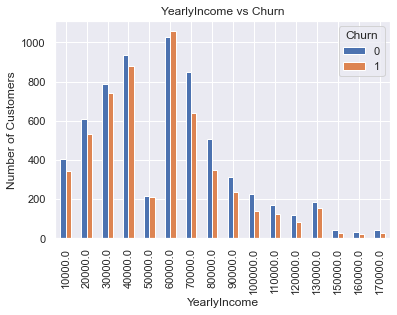

In [393]:
pd.crosstab(modeling_data.YearlyIncome,modeling_data.Churn).plot(kind='bar')
plt.title('YearlyIncome vs Churn')
plt.xlabel('YearlyIncome')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# larger number of non-churners than churners hence it appears as if non-churners earn more than churners in general

## Churn & Commute Distance

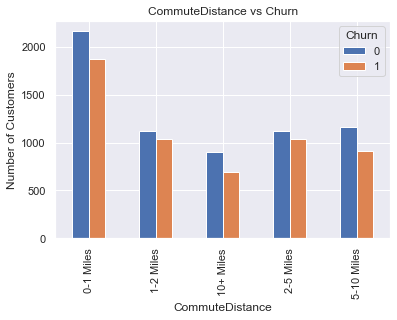

In [394]:
pd.crosstab(modeling_data.CommuteDistance,modeling_data.Churn).plot(kind='bar')
plt.title('CommuteDistance vs Churn')
plt.xlabel('CommuteDistance')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# Customers who travel less than 1 Mile to work are more likely to churn

## Churn & Marital Status

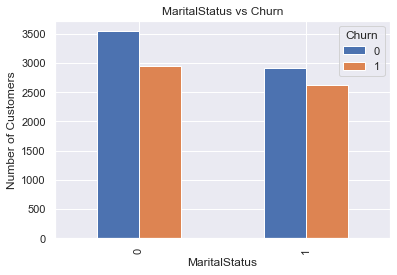

In [524]:
pd.crosstab(modeling_data.MaritalStatus,modeling_data.Churn).plot(kind='bar')
plt.title('MaritalStatus vs Churn')
plt.xlabel('MaritalStatus')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')

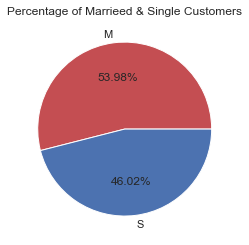

In [397]:
M = modeling_data.loc[modeling_data['MaritalStatus'] == 'M'].count()[0]
S = modeling_data.loc[modeling_data['MaritalStatus'] == 'S'].count()[0]

labels = ['M', 'S']
colors = ['r', 'b']

plt.pie([M, S], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Marrieed & Single Customers')
plt.show() 

### measures of central tendencies - investigating the difference between the averages of independent variables vs the target variables


In [398]:

modeling_data.groupby('Churn').mean()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,NumberCarsOwned,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age
Churn,,,,,,,,,,,,,,,,,,,,,
0,1631.94,874.42,715.01,1035.40,1.60,3.51,2.27,1.90,2.65,58101.50,...,1.53,0.08,0.19,0.08,0.87,0.07,0.08,0.04,5.90,44.02
1,1503.14,1013.76,883.67,1143.00,1.27,2.69,2.16,1.94,2.38,55538.77,...,1.47,0.15,0.17,0.07,0.80,0.14,0.06,0.02,2.97,43.20


In [399]:
modeling_data.isnull().sum()

SalesAmount_sum                0
SalesAmount_mean               0
SalesAmount_min                0
SalesAmount_max                0
SalesOrderNumber_count         0
OrderQuantity_sum              0
OrderQuantity_mean             0
OrderQuantity_min              0
OrderQuantity_max              0
MaritalStatus                  0
Gender                         0
YearlyIncome                   0
TotalChildren                  0
NumberChildrenAtHome           0
EnglishEducation               0
EnglishOccupation              0
HouseOwnerFlag                 0
NumberCarsOwned                0
CommuteDistance                0
Manufacturer                 970
On Promotion                 970
Other                        970
Price                        970
Quality                      970
Review                       970
Television  Advertisement    970
CustomerTenure                 0
Customer_Age                   0
Churn                          0
SalesCountry                   0
SalesRegio

<AxesSubplot:>

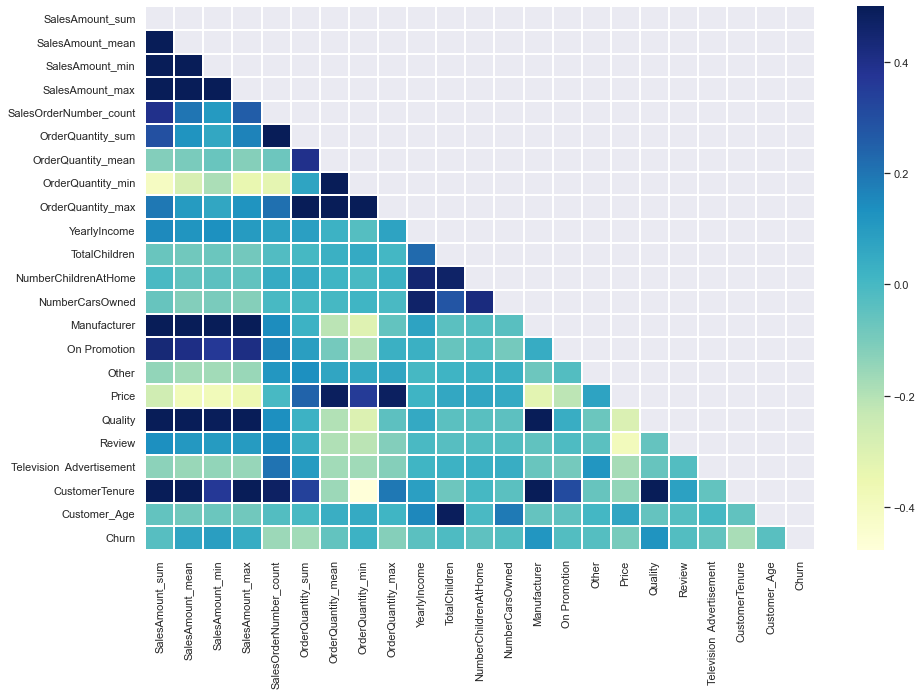

In [400]:
# Calculate correlations

corr = modeling_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            # annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

### Identify missing values

In [401]:
modeling_data.isnull().mean().sort_values(ascending=False)*100

Television  Advertisement   8.07
Review                      8.07
Quality                     8.07
Price                       8.07
Other                       8.07
On Promotion                8.07
Manufacturer                8.07
SalesAmount_sum             0.00
HouseOwnerFlag              0.00
SalesCountry                0.00
Churn                       0.00
Customer_Age                0.00
CustomerTenure              0.00
CommuteDistance             0.00
NumberCarsOwned             0.00
EnglishOccupation           0.00
SalesAmount_mean            0.00
EnglishEducation            0.00
NumberChildrenAtHome        0.00
TotalChildren               0.00
YearlyIncome                0.00
Gender                      0.00
MaritalStatus               0.00
OrderQuantity_max           0.00
OrderQuantity_min           0.00
OrderQuantity_mean          0.00
OrderQuantity_sum           0.00
SalesOrderNumber_count      0.00
SalesAmount_max             0.00
SalesAmount_min             0.00
SalesRegio

In [402]:
#replace missing values with most frequent values

modeling_data = modeling_data.fillna(modeling_data.mode().iloc[0])

In [403]:
# re-check to see all values are filled
modeling_data.isnull().sum()

SalesAmount_sum              0
SalesAmount_mean             0
SalesAmount_min              0
SalesAmount_max              0
SalesOrderNumber_count       0
OrderQuantity_sum            0
OrderQuantity_mean           0
OrderQuantity_min            0
OrderQuantity_max            0
MaritalStatus                0
Gender                       0
YearlyIncome                 0
TotalChildren                0
NumberChildrenAtHome         0
EnglishEducation             0
EnglishOccupation            0
HouseOwnerFlag               0
NumberCarsOwned              0
CommuteDistance              0
Manufacturer                 0
On Promotion                 0
Other                        0
Price                        0
Quality                      0
Review                       0
Television  Advertisement    0
CustomerTenure               0
Customer_Age                 0
Churn                        0
SalesCountry                 0
SalesRegion                  0
dtype: int64

In [404]:
modeling_data.head()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,MaritalStatus,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn,SalesCountry,SalesRegion
0,8248.99,2749.66,2341.97,3399.99,3,8,2.67,1,5,M,...,0.00,1.00,0.00,0.00,0.00,27,41,1,Australia,Pacific
1,8114.04,2704.68,2294.99,3399.99,3,4,1.33,1,2,M,...,0.00,0.00,0.00,0.00,0.00,25,42,1,Australia,Pacific
2,8139.29,2713.10,2318.96,3399.99,3,9,3.00,1,4,S,...,0.00,1.00,0.00,0.00,0.00,28,39,1,Australia,Pacific
3,8196.01,2732.00,2376.96,3399.99,3,6,2.00,1,3,S,...,0.00,1.00,0.00,0.00,0.00,27,33,1,Australia,Pacific
4,8121.33,2707.11,2362.27,3374.99,3,6,2.00,1,4,S,...,0.00,1.00,0.00,0.00,0.00,28,36,1,Australia,Pacific


In [405]:
#Carry out a statistical test to understand key statistical elements
modeling_data.describe()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
count,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,...,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00
mean,1572.39,938.85,793.00,1085.16,1.44,3.13,2.22,1.92,2.52,56916.49,...,0.10,0.17,0.07,0.85,0.09,0.06,0.03,4.54,43.64,0.46
std,2073.17,1067.09,955.01,1254.11,1.02,2.42,0.94,1.05,1.11,31969.69,...,0.30,0.37,0.25,0.35,0.29,0.25,0.18,7.97,11.58,0.50
min,2.29,2.29,2.29,2.29,1.00,1.00,1.00,1.00,1.00,10000.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00
25%,48.97,39.98,38.88,42.84,1.00,2.00,1.50,1.00,2.00,30000.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,34.00,0.00
50%,539.99,229.86,229.86,254.34,1.00,3.00,2.00,2.00,2.00,60000.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,41.00,0.00
75%,2502.03,1888.83,1249.84,2325.96,2.00,4.00,3.00,3.00,3.00,70000.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,7.00,51.00,1.00
max,13295.38,3578.27,3578.27,3578.27,28.00,65.00,8.00,8.00,8.00,170000.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,35.00,96.00,1.00


In [406]:
# check data types
modeling_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

## Variable Selection Using Vote Based Approach

In [407]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
#http://localhost:8888/notebooks/Downloads/Churn%20Model%20From%20Scratch%20(1).ipynb
#4.-Variable-Selection-using-Python---Vote-based-approach
# Encoding the categorical variable
fit = modeling_data.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    modeling_data[i] = d[i].transform(modeling_data[i].fillna('NA'))

In [408]:
features = modeling_data[modeling_data.columns.difference(['Churn'])]
labels = modeling_data['Churn']

In [409]:
features.dtypes

CommuteDistance                int32
CustomerTenure                 int32
Customer_Age                   int32
EnglishEducation               int32
EnglishOccupation              int32
Gender                         int32
HouseOwnerFlag                 int32
Manufacturer                 float64
MaritalStatus                  int32
NumberCarsOwned                int64
NumberChildrenAtHome           int64
On Promotion                 float64
OrderQuantity_max              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_sum              int64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
SalesAmount_max              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_sum              float64
SalesCountry                   int32
SalesOrderNumber_count         int64
SalesRegion                    int32
T

In [410]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [411]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [412]:
final_iv, IV = data_vars(modeling_data[modeling_data.columns.difference(['Churn'])],modeling_data.Churn)

In [413]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
1,CustomerTenure,0.14
25,SalesOrderNumber_count,0.14
15,OrderQuantity_sum,0.14
18,Quality,0.05
7,Manufacturer,0.05
12,OrderQuantity_max,0.04
17,Price,0.03
24,SalesCountry,0.02
26,SalesRegion,0.02
29,YearlyIncome,0.02


## Apply WOE values to your dataframe columns

In [414]:
transform_vars_list = modeling_data.columns.difference(['Churn'])
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [415]:
transform_vars_list

Index(['CommuteDistance', 'CustomerTenure', 'Customer_Age', 'EnglishEducation',
       'EnglishOccupation', 'Gender', 'HouseOwnerFlag', 'Manufacturer',
       'MaritalStatus', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'On Promotion', 'OrderQuantity_max', 'OrderQuantity_mean',
       'OrderQuantity_min', 'OrderQuantity_sum', 'Other', 'Price', 'Quality',
       'Review', 'SalesAmount_max', 'SalesAmount_mean', 'SalesAmount_min',
       'SalesAmount_sum', 'SalesCountry', 'SalesOrderNumber_count',
       'SalesRegion', 'Television  Advertisement', 'TotalChildren',
       'YearlyIncome'],
      dtype='object')

In [416]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            modeling_data[transform_prefix + var] = modeling_data[var].apply(lambda x: eval(replace_cmd))
        except:
            modeling_data[transform_prefix + var] = modeling_data[var].apply(lambda x: eval(replace_cmd1))

## Variable Importance using Random Forest

In [417]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9983363832972884


In [418]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [419]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
2,Customer_Age,0.10
21,SalesAmount_mean,0.09
22,SalesAmount_min,0.08
23,SalesAmount_sum,0.08
20,SalesAmount_max,0.08
1,CustomerTenure,0.08
29,YearlyIncome,0.06
0,CommuteDistance,0.04
28,TotalChildren,0.04
3,EnglishEducation,0.04


## Recursive Feature Elimination

In [420]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

C:\Users\henna\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\henna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\henna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

I

In [421]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [422]:
Selected[Selected['RFE'] == True]

,index,RFE
0,CommuteDistance,True
1,CustomerTenure,True
3,EnglishEducation,True
5,Gender,True
6,HouseOwnerFlag,True
7,Manufacturer,True
8,MaritalStatus,True
10,NumberChildrenAtHome,True
11,On Promotion,True
12,OrderQuantity_max,True


## Variable Importance using Extratrees Classifier

In [423]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.04319903 0.06664177 0.08839315 0.04147317 0.03449738 0.03401633
 0.02330047 0.00755019 0.02846395 0.0393684  0.0294877  0.01041109
 0.01783552 0.01782109 0.01255344 0.0225221  0.00967992 0.00710535
 0.00806065 0.0049972  0.0646484  0.06946981 0.07071474 0.06940205
 0.0360358  0.01874312 0.02232123 0.00286363 0.04235481 0.0560685 ]


In [424]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [425]:
FI = FI.reset_index()

In [426]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
2,Customer_Age,0.09
22,SalesAmount_min,0.07
21,SalesAmount_mean,0.07
23,SalesAmount_sum,0.07
1,CustomerTenure,0.07
20,SalesAmount_max,0.06
29,YearlyIncome,0.06
0,CommuteDistance,0.04
28,TotalChildren,0.04
3,EnglishEducation,0.04


## Chi Square

In [427]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features.abs(), labels)

In [428]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [429]:
chi_sq = chi_sq.reset_index()

In [430]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
29,YearlyIncome,344844.57
22,SalesAmount_min,107200.40
21,SalesAmount_mean,61807.92
20,SalesAmount_max,31885.95
23,SalesAmount_sum,31531.06
1,CustomerTenure,5626.79
15,OrderQuantity_sum,646.75
25,SalesOrderNumber_count,222.11
18,Quality,142.02
7,Manufacturer,122.82


## L1 feature selection

In [431]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

C:\Users\henna\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [432]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [433]:
l1[l1['L1'] == True]

,index,L1
0,CommuteDistance,True
1,CustomerTenure,True
2,Customer_Age,True
4,EnglishOccupation,True
8,MaritalStatus,True
9,NumberCarsOwned,True
10,NumberChildrenAtHome,True
12,OrderQuantity_max,True
14,OrderQuantity_min,True
15,OrderQuantity_sum,True


## Combine all together

In [434]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

## Vote each variable

In [435]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [436]:
score_table['final_score'] = score_table.sum(axis=1)

C:\Users\henna\AppData\Local\Temp/ipykernel_24976/1526511224.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_table['final_score'] = score_table.sum(axis=1)


In [437]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
23,SalesAmount_sum,0,1,1,1,0,1,4
22,SalesAmount_min,0,1,1,1,0,1,4
21,SalesAmount_mean,0,1,1,1,0,1,4
1,CustomerTenure,1,0,1,0,1,1,4
15,OrderQuantity_sum,1,0,0,0,1,1,3
2,Customer_Age,0,1,1,0,0,1,3
20,SalesAmount_max,0,1,0,1,0,1,3
18,Quality,1,0,0,0,1,1,3
14,OrderQuantity_min,0,0,0,0,1,1,2
27,Television Advertisement,0,0,0,0,1,1,2


## Multicollinearity

In [438]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [439]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [440]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [441]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [442]:
list(vif['Features'])

['CommuteDistance',
 'CustomerTenure',
 'Customer_Age',
 'MaritalStatus',
 'NumberChildrenAtHome',
 'OrderQuantity_min',
 'Quality',
 'SalesAmount_min',
 'SalesOrderNumber_count',
 'SalesRegion',
 'Television  Advertisement']

In [443]:
features.describe()

,CommuteDistance,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,SalesRegion,Television Advertisement
count,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00
mean,1.67,4.54,43.64,0.46,0.99,1.92,0.09,793.00,1.44,0.89,0.03
std,1.51,7.97,11.58,0.50,1.51,1.05,0.29,955.01,1.02,0.69,0.18
min,0.00,0.00,25.00,0.00,0.00,1.00,0.00,2.29,1.00,0.00,0.00
25%,0.00,0.00,34.00,0.00,0.00,1.00,0.00,38.88,1.00,0.00,0.00
50%,1.00,0.00,41.00,0.00,0.00,2.00,0.00,229.86,1.00,1.00,0.00
75%,3.00,7.00,51.00,1.00,2.00,3.00,0.00,1249.84,2.00,1.00,0.00
max,4.00,35.00,96.00,1.00,5.00,8.00,1.00,3578.27,28.00,2.00,1.00


In [444]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12022 entries, 0 to 12021
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CommuteDistance            12022 non-null  int32  
 1   CustomerTenure             12022 non-null  int32  
 2   Customer_Age               12022 non-null  int32  
 3   MaritalStatus              12022 non-null  int32  
 4   NumberChildrenAtHome       12022 non-null  int64  
 5   OrderQuantity_min          12022 non-null  int64  
 6   Quality                    12022 non-null  float64
 7   SalesAmount_min            12022 non-null  float64
 8   SalesOrderNumber_count     12022 non-null  int64  
 9   SalesRegion                12022 non-null  int32  
 10  Television  Advertisement  12022 non-null  float64
dtypes: float64(3), int32(5), int64(3)
memory usage: 798.5 KB


In [445]:
features.head()

,CommuteDistance,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,SalesRegion,Television Advertisement
0,1,27,41,0,0,1,0.00,2341.97,3,2,0.00
1,3,25,42,0,3,1,0.00,2294.99,3,2,0.00
2,4,28,39,1,0,1,0.00,2318.96,3,2,0.00
3,1,27,33,1,5,1,0.00,2376.96,3,2,0.00
4,4,28,36,1,0,1,0.00,2362.27,3,2,0.00


## Descriptive Stats and Visualization - For selected variables

In [446]:
#Merge the best list to churn variable
final_vars = list(vif['Features']) + ['Churn']
final_vars

['CommuteDistance',
 'CustomerTenure',
 'Customer_Age',
 'MaritalStatus',
 'NumberChildrenAtHome',
 'OrderQuantity_min',
 'Quality',
 'SalesAmount_min',
 'SalesOrderNumber_count',
 'SalesRegion',
 'Television  Advertisement',
 'Churn']

In [447]:
df1 = modeling_data[final_vars].fillna(0)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12022 entries, 0 to 12021
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CommuteDistance            12022 non-null  int32  
 1   CustomerTenure             12022 non-null  int32  
 2   Customer_Age               12022 non-null  int32  
 3   MaritalStatus              12022 non-null  int32  
 4   NumberChildrenAtHome       12022 non-null  int64  
 5   OrderQuantity_min          12022 non-null  int64  
 6   Quality                    12022 non-null  float64
 7   SalesAmount_min            12022 non-null  float64
 8   SalesOrderNumber_count     12022 non-null  int64  
 9   SalesRegion                12022 non-null  int32  
 10  Television  Advertisement  12022 non-null  float64
 11  Churn                      12022 non-null  int32  
dtypes: float64(3), int32(6), int64(3)
memory usage: 845.4 KB


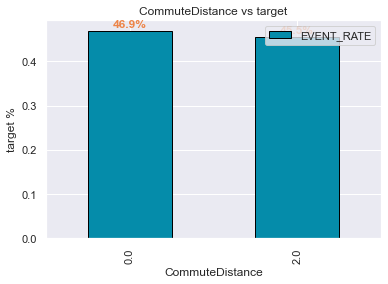

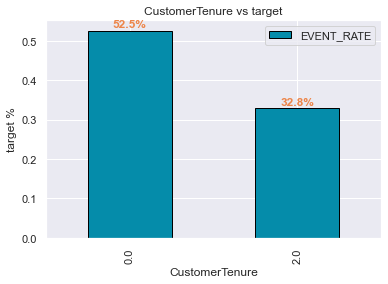

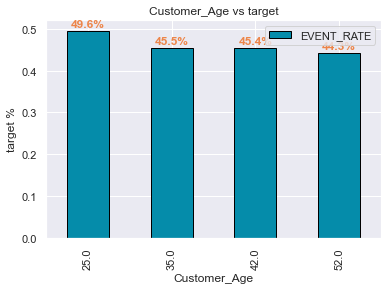

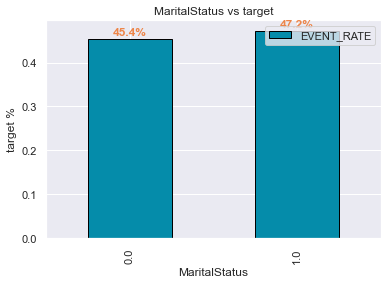

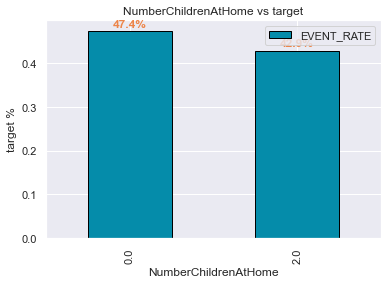

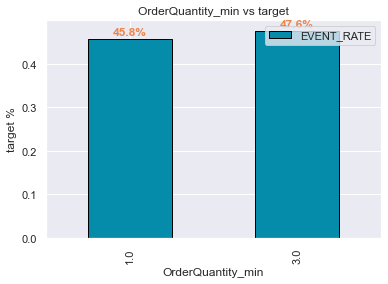

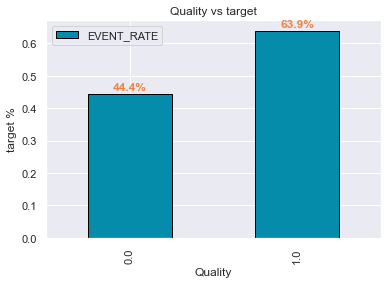

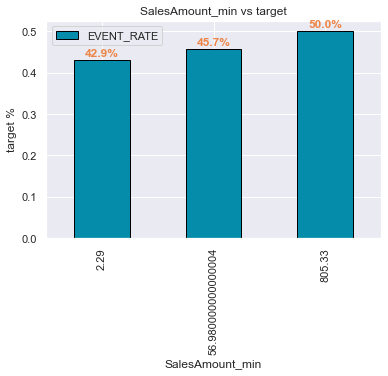

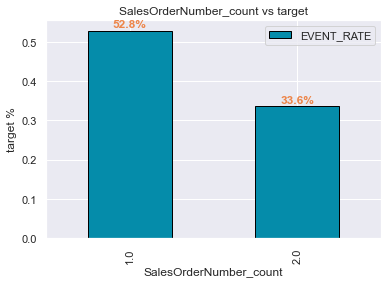

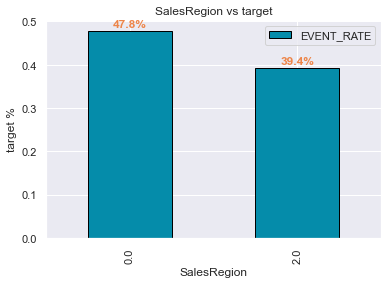

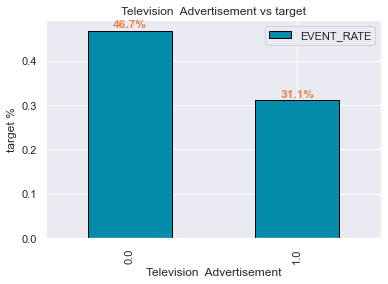

In [448]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['Churn'])
final_iv = final_iv[(final_iv.VAR_NAME != 'Churn')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

## Feature Scaling

In [449]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
HR_col = list(df1.columns)
HR_col.remove('Churn')
for col in HR_col:
    df1[col] = df1[col].astype(float)
    df1[[col]] = scaler.fit_transform(df1[[col]])
df1['Churn'] = pd.to_numeric(df1['Churn'], downcast='float')
df1.head()

,CommuteDistance,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,SalesRegion,Television Advertisement,Churn
0,1.25,3.86,1.13,0.00,0.00,0.00,0.00,3.27,0.37,5.00,0.00,1.00
1,3.75,3.57,1.20,0.00,3.00,0.00,0.00,3.21,0.37,5.00,0.00,1.00
2,5.00,4.00,0.99,5.00,0.00,0.00,0.00,3.24,0.37,5.00,0.00,1.00
3,1.25,3.86,0.56,5.00,5.00,0.00,0.00,3.32,0.37,5.00,0.00,1.00
4,5.00,4.00,0.77,5.00,0.00,0.00,0.00,3.30,0.37,5.00,0.00,1.00


## Cross Validation

In [450]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4, random_state=80)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']
#features = list(vif['Features']) 
#labels = ['Churn']

## Cross Validation with Random Forest

In [451]:
#implement cross validation, the cross_val_score method of the sklearn.model_selection library can be used. 
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=33) 

In [452]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=features_train, y=label_train, cv=10) 

In [453]:
print(all_accuracies) 

[0.6800554  0.64542936 0.65512465 0.65048544 0.68099861 0.68377254
 0.6629681  0.64216366 0.65742025 0.66990291]


In [454]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score

print(all_accuracies.mean()) 

0.662832093007173


In [455]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.014444215799215019


## Let's Try Cross Validation using Logistic Regression

In [456]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [457]:
all_accuracies = cross_val_score(estimator=clf, X=features_train, y=label_train, cv=10)

In [458]:
print(all_accuracies) 

[0.61218837 0.61772853 0.62465374 0.56588072 0.64909847 0.59778086
 0.60471567 0.60887656 0.60887656 0.61997226]


In [459]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score
print(all_accuracies.mean()) 

0.6109771746689155


In [460]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.020060173736622954


## Grid Search for Parameter Selection

#### instead of randomly selecting the values of the parameters, a better approach would be to develop an algorithm which automatically finds the best parameters for a particular model. Grid Search is one such algorithm.

In [461]:
grid_param = {  
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [462]:
from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifier,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)

In [463]:
#Once the GridSearchCV class is initialized, the last step is to call the fit method of the class and pass it the training and 
#test set, as shown in the following code:
gd_sr.fit(features_train, label_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=33),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [464]:
#the next step is to check the parameters that return the highest accuracy
best_parameters = gd_sr.best_params_  
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 150}


In [465]:
#To find the best accuracy achieved, execute the following code:
best_result = gd_sr.best_score_  
print(best_result)

0.6650481594891675


## Models

In [466]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4, random_state = 33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [467]:
all_features = pd.concat([features_train, features_test])
all_labels = pd.concat([label_train, label_test])

## Random Forest 

In [468]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.9897407458755025 0.6654190060303597 0.9996715037736005 0.7469798653059836
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.70      2541
         1.0       0.66      0.60      0.63      2268

    accuracy                           0.67      4809
   macro avg       0.66      0.66      0.66      4809
weighted avg       0.66      0.67      0.66      4809



In [469]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,3875,47
1.00,27,3264


In [470]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1838,703
1.00,906,1362


## LOGISTIC REGRESSION

In [471]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.608207403299598 0.6098981077147017 0.6774507174311099 0.6791665191737343
              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64      2541
         1.0       0.59      0.54      0.57      2268

    accuracy                           0.61      4809
   macro avg       0.61      0.61      0.61      4809
weighted avg       0.61      0.61      0.61      4809



In [472]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,2634,1288
1.00,1538,1753


In [473]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1701,840
1.00,1036,1232


## NAIVE BAYES

In [474]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.592125329266602 0.603243917654398 0.6623739802477698 0.6668980570495722
              precision    recall  f1-score   support

         0.0       0.74      0.38      0.51      2541
         1.0       0.55      0.85      0.67      2268

    accuracy                           0.60      4809
   macro avg       0.65      0.62      0.59      4809
weighted avg       0.65      0.60      0.58      4809



In [475]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1472,2450
1.00,492,2799


In [476]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,978,1563
1.00,345,1923


## KNN

In [477]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.7522528767503119 0.6061551258057808 0.8349975463501202 0.6601218846889843
              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63      2541
         1.0       0.59      0.56      0.57      2268

    accuracy                           0.61      4809
   macro avg       0.60      0.60      0.60      4809
weighted avg       0.61      0.61      0.61      4809



In [478]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,3032,890
1.00,897,2394


In [479]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1634,907
1.00,987,1281


## GRADIENT BOOSTING CLASSIFIER

In [480]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.6790517121863302 0.6440008317737576 0.7775563785522335 0.7365244383642653
              precision    recall  f1-score   support

         0.0       0.64      0.75      0.69      2541
         1.0       0.65      0.52      0.58      2268

    accuracy                           0.64      4809
   macro avg       0.65      0.64      0.64      4809
weighted avg       0.65      0.64      0.64      4809



In [481]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,3044,878
1.00,1437,1854


In [482]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1910,631
1.00,1081,1187


## Performance Tuning for Random Forest

In [483]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
{'n_estimators': 445, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [484]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)


clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.9649244419797588 0.660844250363901 0.9955775420765703 0.7524883792921311
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69      2541
         1.0       0.65      0.60      0.62      2268

    accuracy                           0.66      4809
   macro avg       0.66      0.66      0.66      4809
weighted avg       0.66      0.66      0.66      4809



In [485]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,3813,109
1.00,144,3147


In [486]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1821,720
1.00,911,1357


In [487]:
metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

## Train the final model on all the dataset

In [488]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(all_features,all_labels)

pred_train = clf.predict(all_features)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,all_labels)


from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(all_labels), clf.predict_proba(all_features)[:,1])
auc_train = metrics.auc(fpr,tpr)


print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(label_test, pred_test))

0.675677923806355 0.660844250363901 0.7684391873850838 0.7524883792921311
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69      2541
         1.0       0.65      0.60      0.62      2268

    accuracy                           0.66      4809
   macro avg       0.66      0.66      0.66      4809
weighted avg       0.66      0.66      0.66      4809



In [489]:
#pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])


In [490]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.00,1.00
ACTUAL,,
0.00,1821,720
1.00,911,1357


In [491]:
import bokeh
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)


Loading BokehJS ...

In [492]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

## Decile Plots and KS statistic

In [493]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [494]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [495]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [496]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.0,722.000000,684.000000,38.000000,94.736847,684.000000,38.000000,20.783957,0.968893,19.815063
2.0,721.000000,481.000000,240.000000,66.712898,1165.000000,278.000000,35.399574,7.088220,28.311354
3.0,721.000000,408.000000,313.000000,56.588070,1573.000000,591.000000,47.797020,15.068843,32.728176
4.0,721.000000,374.000000,347.000000,51.872398,1947.000000,938.000000,59.161346,23.916370,35.244976
5.0,721.000000,359.000000,362.000000,49.791954,2306.000000,1300.000000,70.069885,33.146355,36.923531
6.0,722.000000,341.000000,381.000000,47.229916,2647.000000,1681.000000,80.431480,42.860786,37.570694
7.0,721.000000,312.000000,409.000000,43.273232,2959.000000,2090.000000,89.911880,53.289139,36.622742
8.0,721.000000,214.000000,507.000000,29.680998,3173.000000,2597.000000,96.414467,66.216217,30.198250


## Lift chart, Actual vs predicted and Gains chart

In [497]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [498]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')

In [499]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

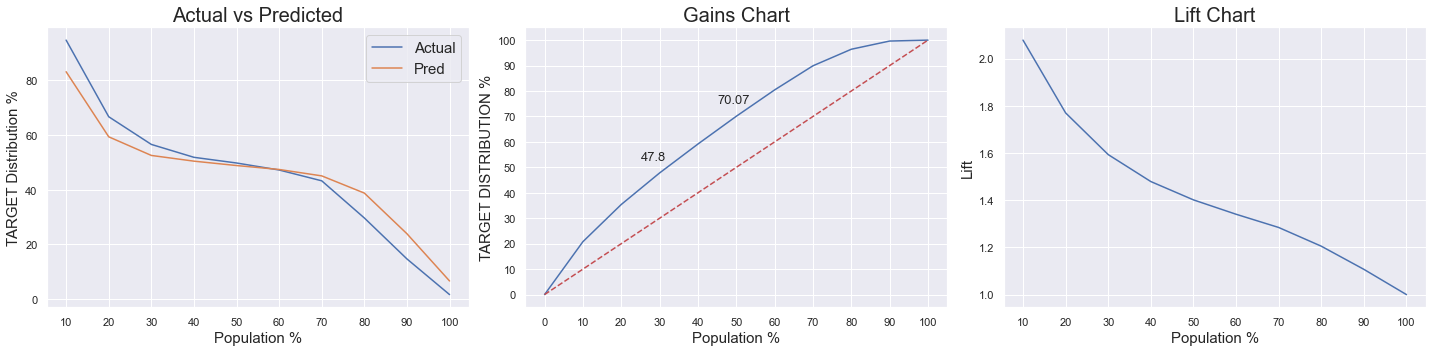

In [500]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

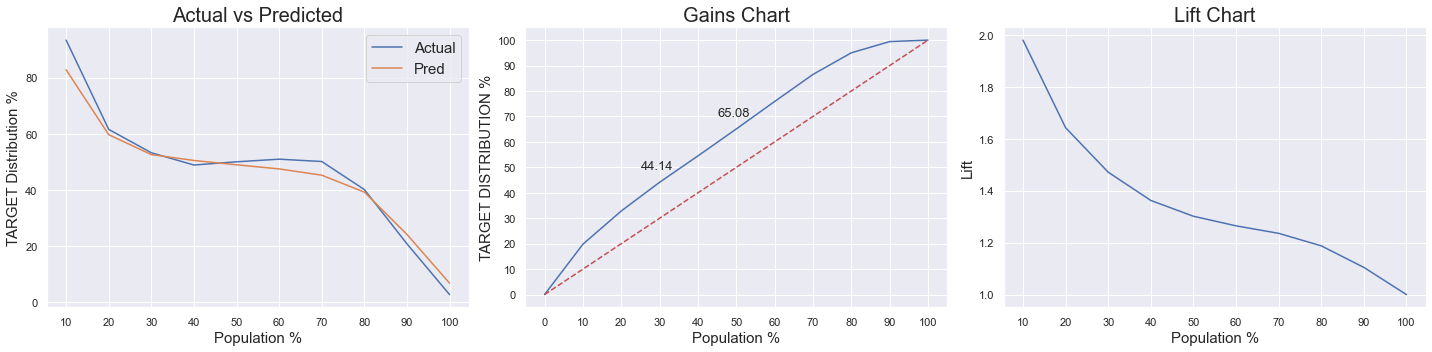

In [501]:
gains(lift_test,['DECILE'],'TARGET','SCORE')

## Save Model for future use

In [502]:
import joblib
filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)



['final_model.model']

## Score New Data

In [503]:
all_features.dtypes

CommuteDistance              float64
CustomerTenure               float64
Customer_Age                 float64
MaritalStatus                float64
NumberChildrenAtHome         float64
OrderQuantity_min            float64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count       float64
SalesRegion                  float64
Television  Advertisement    float64
dtype: object

In [504]:
#Prepare score data to ensure the attributes of the modelling data matches that of the scoring data
#Score_data

#replace missing values with most frequent values
Score_data_sel = scoring_data.fillna(scoring_data.mode().iloc[0])

#Select features and target
Score_data_sel = Score_data_sel[['CommuteDistance','CustomerTenure',
'Customer_Age',
'EnglishOccupation',
'MaritalStatus',
'NumberChildrenAtHome',
'OrderQuantity_min',
'Quality',
'SalesAmount_min',
'SalesOrderNumber_count',
'Television  Advertisement']]

In [505]:
#Select features and target
Score_data_sel.head(5)

,CommuteDistance,CustomerTenure,Customer_Age,EnglishOccupation,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement
7178,10+ Miles,7,58,Management,M,5,1,0.00,21.98,2,0.00
12071,1-2 Miles,0,62,Management,M,0,2,0.00,32.28,1,0.00
5460,2-5 Miles,5,31,Clerical,S,0,2,0.00,7.28,2,0.00
892,0-1 Miles,22,38,Management,M,0,1,0.00,2334.97,3,0.00
13080,0-1 Miles,0,32,Manual,M,2,2,0.00,53.98,1,0.00


In [506]:
Score_data_sel.dtypes

CommuteDistance               object
CustomerTenure                 int32
Customer_Age                   int32
EnglishOccupation             object
MaritalStatus                 object
NumberChildrenAtHome           int64
OrderQuantity_min              int64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
dtype: object

In [507]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

#4.-Variable-Selection-using-Python---Vote-based-approach
# Encoding the categorical variable
fit = Score_data_sel.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    Score_data_sel[i] = d[i].transform(Score_data_sel[i].fillna('NA'))

In [508]:
Score_data_sel.dtypes

CommuteDistance                int32
CustomerTenure                 int32
Customer_Age                   int32
EnglishOccupation              int32
MaritalStatus                  int32
NumberChildrenAtHome           int64
OrderQuantity_min              int64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
dtype: object

In [509]:
# Use the code to load the model
filename = 'final_model.model'

import joblib
d,clf=joblib.load(filename)

In [510]:
#Score the final model (Random Forest) 
pred_train = clf.predict(Score_data_sel)

In [511]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [512]:
scores = score_new(Score_data_sel,clf)


In [513]:
# How many 0s and 1s are there

print('There are', np.count_nonzero(pred_train == 0), '0s')

print('There are', np.count_nonzero(pred_train == 1), '1s')

There are 3081 0s
There are 3381 1s


In [514]:
# Goal: Maximum profit

In [515]:
# Calculate average revenue per customer for a year
# Find latest date of sales data
max(fis['OrderDate'])

Timestamp('2014-01-28 00:00:00')

In [516]:
# Find earliest date of sales data
min(fis['OrderDate'])

Timestamp('2010-12-29 00:00:00')

In [517]:
# Summarise sales by Order Date
daily_sales = fis.groupby('OrderDate').agg({'SalesAmount':'sum'})
daily_sales.head()

,SalesAmount
OrderDate,
2010-12-29,14477.34
2010-12-30,13931.52
2010-12-31,15012.18
2011-01-01,7156.54
2011-01-02,15012.18


In [518]:
# Summarise data by monthly sales
monthly_sales = daily_sales.resample('MS').sum()
monthly_sales.head()

,SalesAmount
OrderDate,
2010-12-01,43421.04
2011-01-01,469823.91
2011-02-01,466334.90
2011-03-01,485198.66
2011-04-01,502073.85


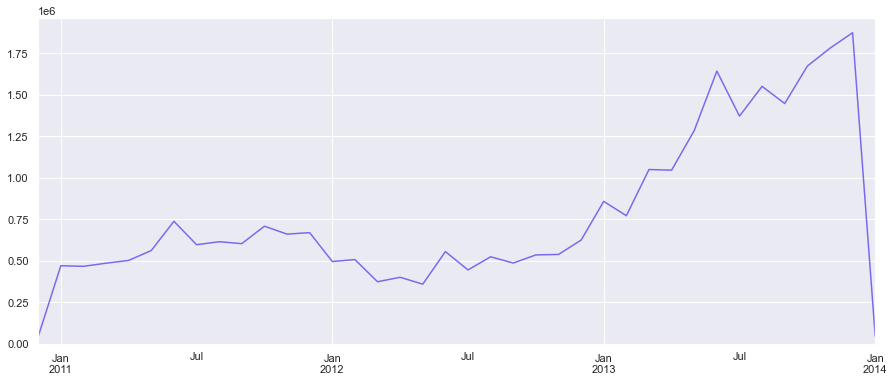

In [519]:
# Plot data
ax = monthly_sales['SalesAmount'].plot(figsize=(15, 6), color = 'mediumslateblue')
ax.xaxis.set_label_text("")
ax.set_ylim(ymin=0)
pass